In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import shutil
import os
phi_dir='ae518_plots/phi_distribution_plots'
error_dir='ae518_plots/error_plots'
if not os.path.exists(phi_dir):
    os.makedirs(phi_dir)
if not os.path.exists(error_dir):
    os.makedirs(error_dir)
# Run -defaults write org.python.python ApplePersistenceIgnoreState NO- before executing -python3 <filename>- if running from mac terminal

# Solver Class

In [2]:
class solver():

  def __init__(self,
              scheme_acronym, 
              fluid_velocity = 1,
              fluid_density = 0.5,
              Gamma = 0.5,
              domain_L = 1,
              inlet_bc = 100,
              outlet_bc = 20,
              gridpoints = 10
              ):
    
    # Global Attributes
    self.scheme = scheme_acronym
    self.angp_ratio = 50
    
    self.u = fluid_velocity
    self.rho = fluid_density
    self.Gamma = Gamma
    self.L = domain_L
    self.dx = self.L/gridpoints
    self.global_Pe = self.rho * self.u * self.L / self.Gamma
    self.local_Pe = self.rho * self.u * self.dx / self.Gamma
    
    self.x = np.linspace(0,self.L,gridpoints)
    self.analytical_x = np.linspace(0,self.L,self.angp_ratio*gridpoints)
    self.phi_0 = inlet_bc
    self.phi_L = outlet_bc
    
    self.analytical_phi = np.zeros(self.angp_ratio*gridpoints)
    self.phi = np.zeros(gridpoints)
    self.P = np.zeros(gridpoints)
    self.Q = np.zeros(gridpoints)
    self.error = 0

    #Solve for phi and calc error
    if self.scheme == "CDS": self.CDS()
    elif self.scheme == "UDS": self.UDS()
    elif self.scheme == "PLDS": self.PLDS()
    self.analytical_soln()
    self.numerical_error()

  # Getter methods
  def get_local_Pe(self): return self.local_Pe
  def get_x(self): return self.x
  def get_anx(self): return self.analytical_x
  def get_P(self): return self.P
  def get_Q(self): return self.Q
  def get_numerical_phi(self): return self.phi
  def get_analytical_phi(self): return self.analytical_phi
  def get_rho(self): return self.rho
  def get_u(self): return self.u
  def get_Gamma(self): return self.Gamma
  def get_gridpoint_n(self): return int(self.L/self.dx)
  def get_dx(self): return self.dx
  def get_error(self): return self.error


  # Discretization Schemes
  def CDS(self):
    D = self.Gamma / self.dx
    F = self.rho * self.u
    #Coefficients
    a = 2*D
    b = D - 0.5 * F
    c = D + 0.5 * F

    self.TDMA(a,b,c)
  
  def UDS(self):
    D = self.Gamma / self.dx
    F = self.rho * self.u
    #Coefficients
    a = 2*D + max(F,0) + max(-F,0)
    b = D + max(-F,0)
    c = D + max(F,0)
  
    self.TDMA(a,b,c)

  def PLDS(self):
    D = self.Gamma / self.dx
    F = self.rho * self.u
    #Coefficients
    b = D*max((1-0.1*self.local_Pe)**5,0) + max(-F,0)
    c = D*max((1-0.1*self.local_Pe)**5,0) + max(F,0)
    a = b + c
  
    self.TDMA(a,b,c)




  ## Use Linear Algebraic Equation Solution Algorithm TDMA
  def TDMA(self,a,b,c):
    # Set BCs
    self.P[0], self.P[-1] = 0,0
    self.Q[0], self.Q[-1] = self.phi_0, self.phi_L

    # Forward Pass to calculate P and Q
    for i in [x+1 for x in range(len(self.x)-2)]:
      self.P[i] = b / (a - c*self.P[i-1])
      self.Q[i] = c*self.Q[i-1] / (a - c*self.P[i-1])

    # Backward Pass to calculate phi
    self.phi[-1] = self.Q[-1]
    for i in [y for y in range(len(self.x)-1)][::-1]:
      self.phi[i] = self.P[i] * self.phi[i+1] + self.Q[i]
  



  def analytical_soln(self):
    if self.u == 0:
      self.analytical_phi = (self.phi_L-self.phi_0)/self.L * self.analytical_x + self.phi_0
    else:
      self.analytical_phi = self.phi_0 + (np.exp(self.global_Pe * self.analytical_x/self.L)-1)/(np.exp(self.global_Pe)-1) * (self.phi_L-self.phi_0)

  def numerical_error(self):
    for i in range(len(self.phi)):
      self.error += 100*self.dx/self.L * (self.phi[i]-self.analytical_phi[self.angp_ratio*i])/self.analytical_phi[self.angp_ratio*i]
    

  

# Plotting Functions

In [8]:
def phi_distribution_plot(velocity, gridpoints):

  temp_dir_one = f'{phi_dir}/Individual_tests'
  if os.path.exists(temp_dir_one):
    shutil.rmtree(temp_dir_one)
  os.makedirs(temp_dir_one)
  
  # Solve for phi
  start_time = time.time()
  solve_CDS = solver('CDS',fluid_velocity=velocity,gridpoints=gridpoints)
  end_time = time.time()
  CDS_time = end_time-start_time

  start_time = time.time()
  solve_UDS = solver('UDS',fluid_velocity=velocity,gridpoints=gridpoints)
  end_time = time.time()
  UDS_time = end_time-start_time

  start_time = time.time()
  solve_PLDS = solver('PLDS',fluid_velocity=velocity,gridpoints=gridpoints)
  end_time = time.time()
  PLDS_time = end_time-start_time

  status_str = f"""Domain properties are set to: \n
      Gamma_phi = {solve_CDS.get_Gamma()} \n
      Fluid Density = {solve_CDS.get_rho()} kg/m^3\n
      Fluid Velocity = {solve_CDS.get_u()} m/s\n
      Number of Gridpoints = {solve_CDS.get_gridpoint_n()}\n
      |Local Pe| = {abs(solve_CDS.get_local_Pe())}\n
      
      It took {CDS_time}s to solve the equation w/ CDS\n
      It took {UDS_time}s to solve the equation w/ UDS\n
      It took {PLDS_time}s to solve the equation w/ PLDS\n
      PLDS % Error = {round(solve_CDS.get_error(),2)}\n
      CDS % Error = {round(solve_UDS.get_error(),2)}\n
      UDS % Error = {round(solve_PLDS.get_error(),2)}\n
      
      Saving plot of phi distribution along the domain to {phi_dir}/u{int(velocity)}_gridpoints{gridpoints}...\n\n
      """


  # Plot phi
  fig = plt.figure()
  plt.plot(solve_CDS.get_anx(),solve_CDS.get_analytical_phi(),label='Analytical Solution')
  plt.plot(solve_CDS.get_x(),solve_CDS.get_numerical_phi(),label=f'Numerical Solution (CDS)',linewidth=0.75)
  plt.plot(solve_UDS.get_x(),solve_UDS.get_numerical_phi(),label=f'Numerical Solution (UDS)',linewidth=0.75)
  plt.plot(solve_PLDS.get_x(),solve_PLDS.get_numerical_phi(),label=f'Numerical Solution (PLDS)',linewidth=0.75)
      

  plt.title(fr'Distribution of $\phi$ along the domain (u={int(velocity)}m/s, gridpoints={gridpoints})')
  plt.xlabel('x (m)')
  plt.ylabel(r'$\phi$')
  plt.legend()
  plt.savefig(f'{phi_dir}/u{int(velocity)}_gp{gridpoints}',dpi=800)

  return status_str


In [5]:

## Plot error (all schemes) for different u values
def scheme_errors():
  
  # Crete folder for plots
  temp_dir = f'{error_dir}/scheme_errors'
  if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
  os.makedirs(temp_dir)
  
  for velocity in np.linspace(-50,50,11):
    fig = plt.figure()
    for scheme in ['CDS','UDS','PLDS']:
      error_list = []
      gp_list = np.linspace(1,50,50-1)
      for gridpoints in gp_list:
        solve = solver(scheme,fluid_velocity=velocity,gridpoints=int(gridpoints))
        error_list.append(solve.get_error())
      
      plt.plot(gp_list,error_list,label=f'scheme = {scheme}')
      plt.title(f'Error of numerical Solution for u={velocity}m/s')
      plt.ylabel('% Error ')
      plt.xlabel('Number of Gridpoints (1/dx)')

    plt.legend()
    # plt.ylim(-20,20)
    plt.savefig(f'{temp_dir}/error_(u{int(velocity)})',dpi=800)


In [6]:
## Plot error (range of u values) for different schemes
def scheme_errors_func_u():
  temp_dir = f'{error_dir}/scheme_errors_func_u'
  if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
  os.makedirs(temp_dir)

  for scheme in ['CDS','UDS','PLDS']:
    fig = plt.figure()
    max_gp = 200
    for u in np.linspace(-10,10,11):
      error_list = []
      gp_list = np.linspace(1,max_gp,max_gp-1)
      for gridpoints in gp_list:
        solve = solver(scheme,gridpoints=int(gridpoints),fluid_velocity=u)
        error_list.append(solve.get_error())


      plt.plot(gp_list,error_list, linewidth=0.5, label=f'u = {u}m/s')
      plt.title(f'Error of numerical {scheme} Solution w.r.t the Analytical Solution')
      plt.ylabel('% Error ')
      plt.xlabel('Number of Gridpoints (1/dx)')

    plt.legend(loc='lower right',prop={'size': 6})
    plt.savefig(f'{temp_dir}/{scheme}_error_f(u)',dpi=800)

# Main

You can find plots of a range of parameters in the ae518_plots directory, This UI allows individual combinations of velocity and gridpoint number to be tested.

What constant fluid velocity would you like to test? Please enter an integer or float.
The constant fluid velocity in the domain has been set to 1 m/s
What number of gridpoints would you like to test? Please enter an integer.
The number of gridpoints in the domain has been set to 1 
Solving equation in the Domain ...


'Domain properties are set to: \n\n      Gamma_phi = 0.5 \n\n      Fluid Density = 0.5 kg/m^3\n\n      Fluid Velocity = 1 m/s\n\n      Number of Gridpoints = 1\n\n      |Local Pe| = 1.0\n\n      \n      It took 0.00020933151245117188s to solve the equation w/ CDS\n\n      It took 0.00012493133544921875s to solve the equation w/ UDS\n\n      It took 0.00011897087097167969s to solve the equation w/ PLDS\n\n      PLDS % Error = -80.0\n\n      CDS % Error = -80.0\n\n      UDS % Error = -80.0\n\n      \n      Saving plot of phi distribution along the domain to ae518_plots/phi_distribution_plots/u1_gridpoints1...\n\n\n      '

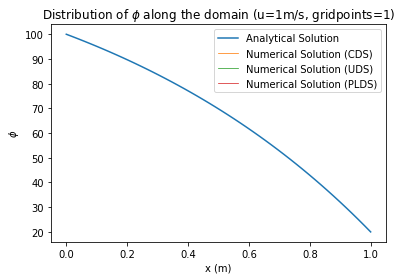

In [15]:
# scheme_dict = {'CDS':'Central Differencing Scheme',
#                'UDS':'Upwind Differencing Scheme',
#                'PLDS':'Power Law Differencing Scheme'}


#Ask user what fluid velocity and number of gridpoints they would like to try
print('You can find plots of a range of parameters in the ae518_plots directory, This UI allows individual combinations of velocity and gridpoint number to be tested.\n')

attribute_prompt = {'constant fluid velocity':('m/s',' or float'),
                    'number of gridpoints':('','')}
for attribute, dec in attribute_prompt.items():
  while True:
    print(f"What {attribute} would you like to test? Please enter an integer{dec[1]}.")
    num_attribute = input()
    try: num_attribute = int(num_attribute)
    except ValueError:
      try: num_attribute = float(num_attribute)
      except ValueError: continue
    if attribute == 'constant fluid velocity': 
      velocity = num_attribute
      print(f'The {attribute} in the domain has been set to {velocity} {dec[0]}')
    if attribute == 'number of gridpoints': 
      gridpoints = int(num_attribute)
      print(f'The {attribute} in the domain has been set to {gridpoints} {dec[0]}')
    break

print('Solving equation in the Domain ...')
phi_distribution_plot(velocity,gridpoints)
  

#Ask user what type of differencing scheme they would like to try
# while True:
#   print("Please choose a discretization scheme. Type one of the following options into the command prompt: \n\tCDS \n\tUDS \n\tPLDS")
#   scheme_text = input()
#   if scheme_text in ['CDS','UDS','PLDS']: break
#   print("Please ensure you have entered the acronym in all caps with no spaces!")
# print(f"You have chosen to discretize the convection component of the phi convection-diffusion equation with the {scheme_dict[scheme_text]}\n\n")

#Plot the numerical solution against the analytical solution


In [ ]:
# Crete folder for plots
sweep_dir = f'{phi_dir}/Sweep'
if os.path.exists(sweep_dir):
  shutil.rmtree(sweep_dir)
os.makedirs(sweep_dir)

for velocity in [-20,-5,0,5,20]:
  for gridpoints in [5,10,20,50,100,200,500]:
    phi_distribution_plot(velocity,gridpoints)

# Error Plots